In [10]:
from pathlib import Path
import dicom_contour.contour as dcm

In [9]:
image_path = '/home/kerem/Desktop/2017-05__Studies/OPC117_OPC117_CT_2017-05-04_142858_RT^LUNG.(Adult)_LUNG..3.0..B31f.CROPPED_n80__00000/'
rt_path = '/home/kerem/Desktop/2017-05__Studies/OPC117_OPC117_RTst_2017-05-04_142858_RT^LUNG.(Adult)_ReadyAtlasV1_n1__00000/'

In [13]:
contour_filename = str(list(Path(rt_path).iterdir())[1])

In [311]:
contour_filename

'/home/kerem/Desktop/2017-05__Studies/OPC117_OPC117_RTst_2017-05-04_142858_RT^LUNG.(Adult)_ReadyAtlasV1_n1__00000/2.16.840.1.114362.1.11738497.21988995044.483828650.1031.8733.dcm'

In [29]:
# read dataset for contour
rt_sequence = dicom.read_file(contour_filename)

In [261]:
#extract roi index in RT Struct
np.where(np.array(dcm.get_roi_names(contour_file)) == "Ventricles")[0][0]

21

In [262]:
type(rt_sequence)

dicom.dataset.FileDataset

In [297]:
def parse_dicom_file(filename):
    """Parse the given DICOM filename
    :param filename: filepath to the DICOM file to parse
    :return: dictionary with DICOM image data
    """

    try:
        dcm = dicom.read_file(filename)
        dcm_image = dcm.pixel_array

        try:
            intercept = dcm.RescaleIntercept
        except AttributeError:
            intercept = 0.0
        try:
            slope = dcm.RescaleSlope
        except AttributeError:
            slope = 0.0

        if intercept != 0.0 and slope != 0.0:
            dcm_image = dcm_image*slope + intercept
        return dcm_image
    except InvalidDicomError:
        return None

In [273]:
def get_roi_contour_ds(rt_sequence, index):
    """
    Extract desired ROI contour datasets
    from RT Sequence.
    
    E.g. rt_sequence can have contours for different parts of the brain 
    such as ventricles, tumor, etc...
    
    You can use get_roi_names to find which index to use
    
    Inputs:
        rt_sequence (dicom.dataset.FileDataset): Contour file dataset, what you get 
                                                 after reading contour DICOM file
        index (int): Index for ROI Sequence
    Return:
        contours (list): list of ROI contour dicom.dataset.Dataset s
    """
    # index 0 means that we are getting RTV information
    ROI = rt_sequence.ROIContourSequence[index]
    # get contour datasets in a list
    contours = [contour for contour in ROI.ContourSequence]
    return contours

In [274]:
contour_datasets = get_roi_contour_ds(rt_sequence=rt_sequence, index=21)

In [275]:
type(contour_datasets[0])

dicom.dataset.Dataset

In [269]:
def contour2poly(contour_dataset, path):
    """
    Given a contour dataset (a DICOM class) and path that has .dcm files of
    corresponding images return polygon coordinates for the contours.

    Inputs
        contour_dataset (dicom.dataset.Dataset) : DICOM dataset class that is identified as
                         (3006, 0016)  Contour Image Sequence
        path (str): path of directory containing DICOM images

    Return:
        pixel_coords (list): list of tuples having pixel coordinates
        img_ID (id): DICOM image id which maps input contour dataset
        img_shape (tuple): DICOM image shape - height, width
    """

    contour_coord = contour_dataset.ContourData
    # x, y, z coordinates of the contour in mm
    coord = []
    for i in range(0, len(contour_coord), 3):
        coord.append((contour_coord[i], contour_coord[i + 1], contour_coord[i + 2]))

    # extract the image id corresponding to given countour
    # read that dicom file
    img_ID = contour_dataset.ContourImageSequence[0].ReferencedSOPInstanceUID
    img = dicom.read_file(path + img_ID + '.dcm')
    img_arr = img.pixel_array
    img_shape = img_arr.shape
    
    # physical distance between the center of each pixel
    x_spacing, y_spacing = float(img.PixelSpacing[0]), float(img.PixelSpacing[1])

    # this is the center of the upper left voxel
    origin_x, origin_y, _ = img.ImagePositionPatient

    # y, x is how it's mapped
    pixel_coords = [(np.ceil((x - origin_x) / x_spacing), np.ceil((y - origin_y) / y_spacing))  for x, y, _ in coord]
    return pixel_coords, img_ID, img_shape

In [270]:
def poly_to_mask(polygon, width, height):
    from PIL import Image, ImageDraw
    
    """Convert polygon to mask
    :param polygon: list of pairs of x, y coords [(x1, y1), (x2, y2), ...]
     in units of pixels
    :param width: scalar image width
    :param height: scalar image height
    :return: Boolean mask of shape (height, width)
    """

    # http://stackoverflow.com/a/3732128/1410871
    img = Image.new(mode='L', size=(width, height), color=0)
    ImageDraw.Draw(img).polygon(xy=polygon, outline=0, fill=1)
    mask = np.array(img).astype(bool)
    return mask

In [294]:
def get_mask_dict(contour_datasets, path):
    """
    Inputs:
        contour_datasets (list): list of dicom.dataset.Dataset for contours
        path (str): path of directory with images

    Return:
        img_contours_dict (dict): img_id : contour array pairs
    """
    
    from collections import defaultdict
    
    # create empty dict for 
    img_contours_dict = defaultdict(int)

    for cdataset in contour_datasets:
        coords, img_id, shape = contour2poly(cdataset, path)
        mask = poly_to_mask(coords, *shape)
        img_contours_dict[img_id] += mask
    
    return img_contours_dict

In [295]:
mask_dict = get_mask_dict(contour_datasets, image_path)

In [291]:
slice_orders = slice_order(image_path)

In [310]:
def get_img_mask_voxel(slice_orders, mask_dict, image_path):
    """ 
    Construct image and mask voxels
    
    Inputs:
        slice_orders (list): list of tuples of ordered img_id and z-coordinate position
        mask_dict (dict): dictionary having img_id : contour array pairs
        image_path (str): directory path containing DICOM image files
    Return: 
        img_voxel: ordered image voxel for CT/MR
        mask_voxel: ordered mask voxel for CT/MR
    """
    
    img_voxel = []
    mask_voxel = []
    for img_id, _ in slice_orders:
        img_array = parse_dicom_file(image_path + img_id + '.dcm')
        if img_id in mask_dict: mask_array = mask_dict[img_id]
        else: mask_array = np.zeros_like(img_array)
        img_voxel.append(img_array)
        mask_voxel.append(mask_array)
    return img_voxel, mask_voxel

In [309]:
img_data, mask_data = get_img_mask_voxel(slice_orders, mask_dict)

In [ ]:
#### Full pipeline for getting img - mask data for a patient
image_path = '/home/kerem/Desktop/2017-05__Studies/\
OPC117_OPC117_CT_2017-05-04_142858_RT^LUNG.(Adult)_LUNG..3.0..B31f.CROPPED_n80__00000/'

contour_filename = '/home/kerem/Desktop/2017-05__Studies/\
OPC117_OPC117_RTst_2017-05-04_142858_RT^LUNG.(Adult)_ReadyAtlasV1_n1__00000/\
2.16.840.1.114362.1.11738497.21988995044.483828650.1031.8733.dcm'


# read dataset for contour
rt_sequence = dicom.read_file(contour_filename)


# get contour datasets with index idx
idx = 21
contour_datasets = get_roi_contour_ds(rt_sequence, idx)

# construct mask dictionary
mask_dict = get_mask_dict(contour_datasets, image_path)

# get slice orders
slice_orders = slice_order(image_path)

# get image and mask data for patient
img_data, mask_data = get_img_mask_voxel(slice_orders, mask_dict)

In [313]:
def get_data(image_path, contour_filename, roi_index):
    """
    Given image_path, contour_filename and roi_index return
    image and mask voxel array
    
    Inputs:
        image_path (str): directory path containing DICOM image files
        contour_filename (str): absolute filename for DICOM contour file
        roi_index (int): index for desired ROI from RT Struct
    Return:
        img_voxel (np.array): 3 dimensional numpy array of ordered images
        mask_voxel (np.array): 3 dimensional numpy array of ordered masks
    """
    # read dataset for contour
    rt_sequence = dicom.read_file(contour_filename)

    # get contour datasets with index idx
    contour_datasets = get_roi_contour_ds(rt_sequence, roi_index)

    # construct mask dictionary
    mask_dict = get_mask_dict(contour_datasets, image_path)

    # get slice orders
    slice_orders = slice_order(image_path)

    # get image and mask data for patient
    img_voxel, mask_voxel = get_img_mask_voxel(slice_orders, mask_dict, image_path)
    return img_voxel, mask_voxel

In [ ]:
def show_img_msk_fromarray(img_arr, msk_arr, alpha=0.35, sz=7, cmap='inferno',
                           save_path=None):

    """
    Show original image and masked on top of image
    next to each other in desired size
    Inputs:
        img_arr (np.array): array of the image
        msk_arr (np.array): array of the mask
        alpha (float): a number between 0 and 1 for mask transparency
        sz (int): figure size for display
        save_path (str): path to save the figure
    """

    msk_arr = np.ma.masked_where(msk_arr == 0, msk_arr)
    plt.figure(figsize=(sz, sz))
    plt.subplot(1, 2, 1)
    plt.imshow(img_arr, cmap='gray')
    plt.imshow(msk_arr, cmap=cmap, alpha=alpha)
    plt.subplot(1, 2, 2)
    plt.imshow(img_arr, cmap='gray')
    if save_path is None:
        plt.show()
    else:
        plt.savefig(save_path)
        plt.close()

In [314]:
contour_data = dicom.read_file(contour_filename)

In [315]:
get_roi_names(contour_data)

['Brainstem',
 'SpinalCord',
 'Parotid_R',
 'Parotid_L',
 'Submandibular_R',
 'Mandible',
 'TMjoint_R',
 'TMjoint_L',
 'Esophagus',
 'Larynx',
 'Epiglottis',
 'Pharynx',
 'Thyroid',
 'OralCavity',
 'Brain',
 'Eye_R',
 'Eye_L',
 'Lens_L',
 'Lens_R',
 'Cochlea_L',
 'Cochlea_R',
 'Ventricles']

In [321]:
img_voxel, mask_voxel = get_data(image_path, contour_filename, roi_index=-8)

/home/kerem/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/image.py:405: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/home/kerem/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/image.py:406: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
/home/kerem/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/image.py:412: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/kerem/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/image.py:417: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/kerem/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/colors.py:905: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/home/kerem/anaconda3/envs/fastai/lib/python3.6/site-packages/numpy/ma/core.py:716: UserWarning: Warning: convert

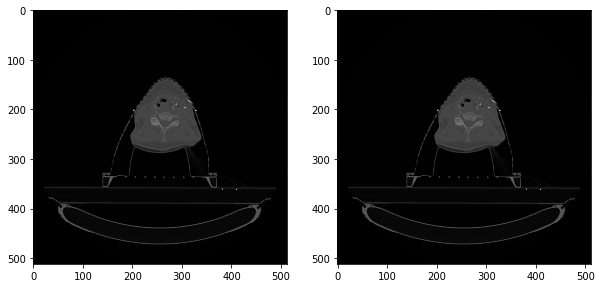

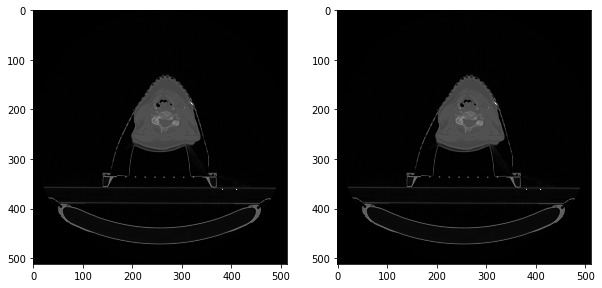

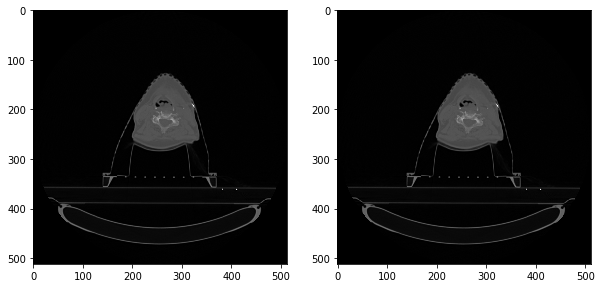

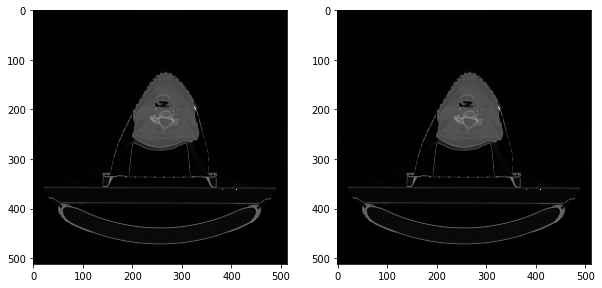

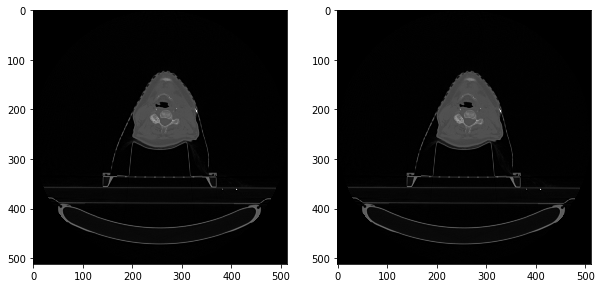

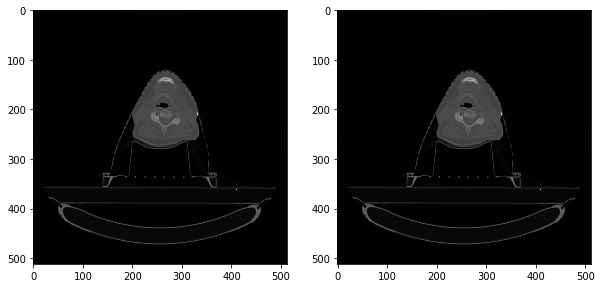

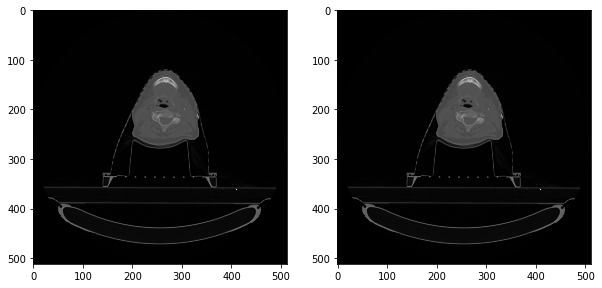

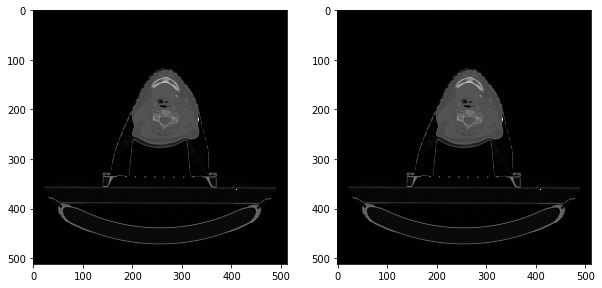

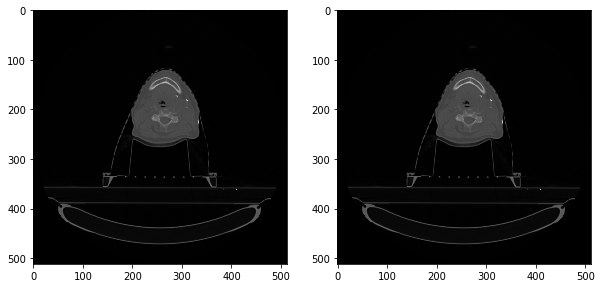

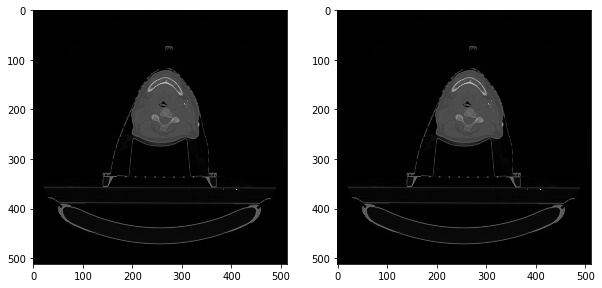

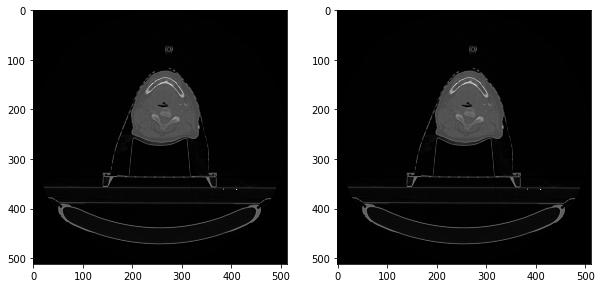

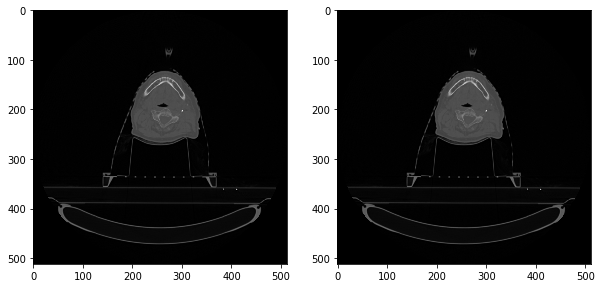

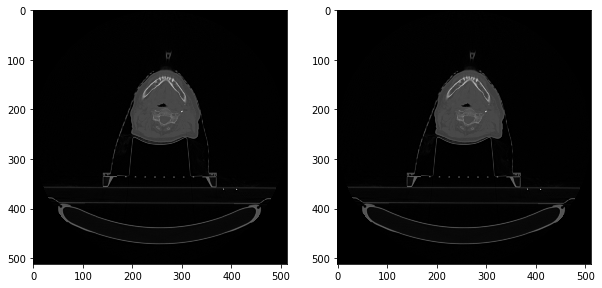

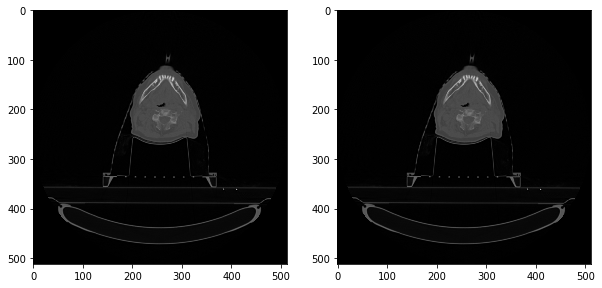

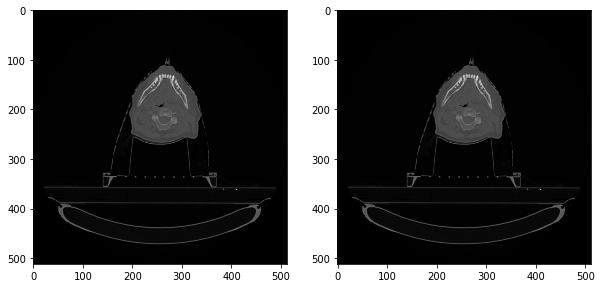

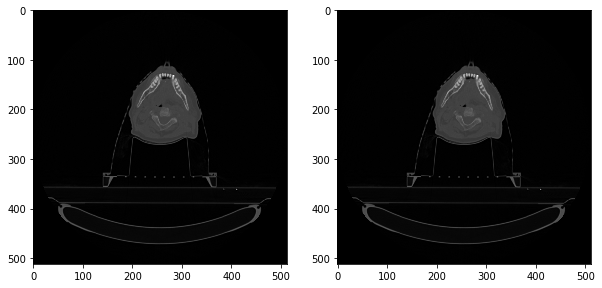

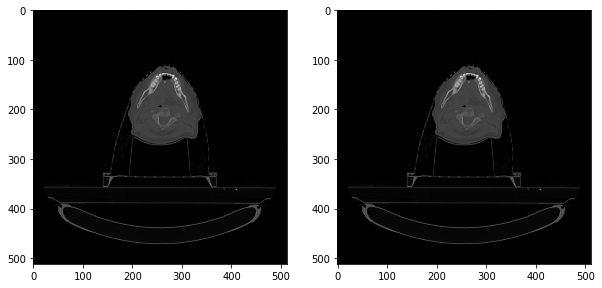

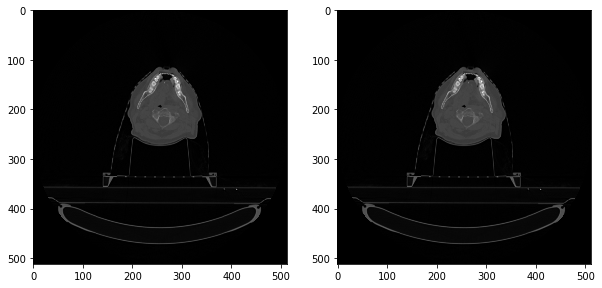

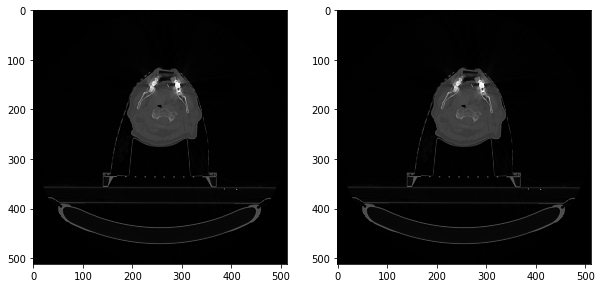

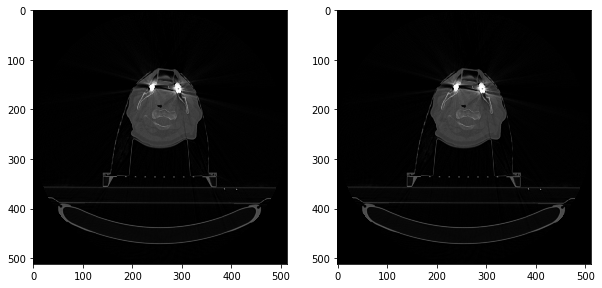

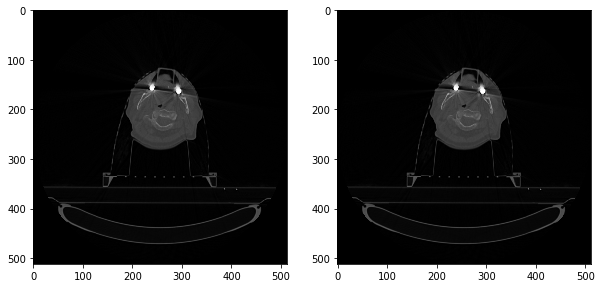

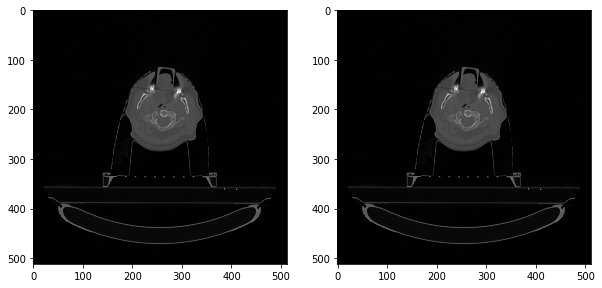

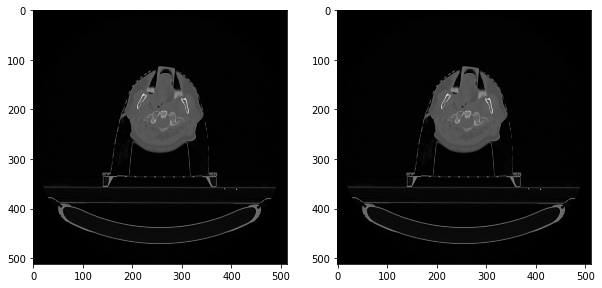

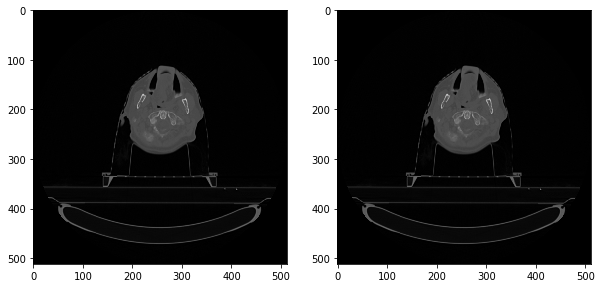

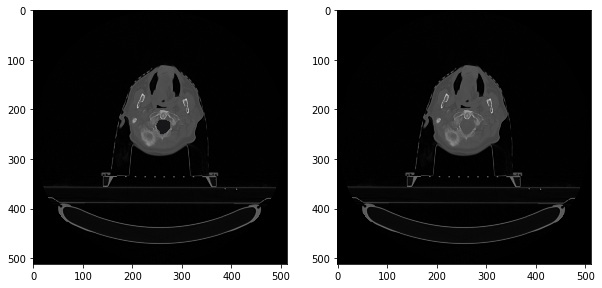

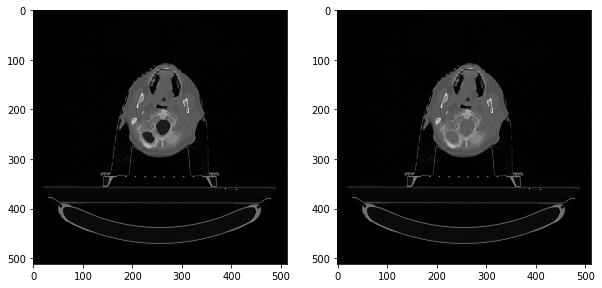

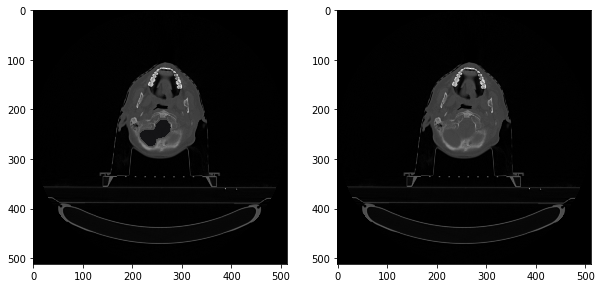

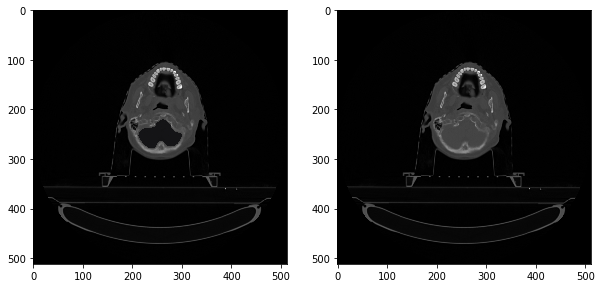

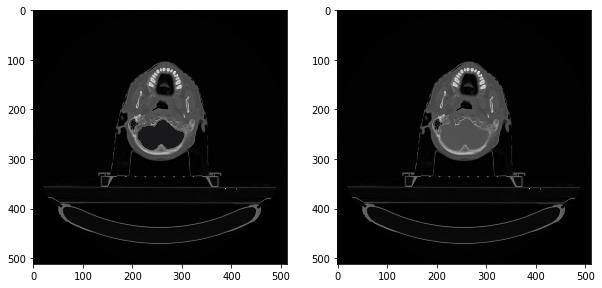

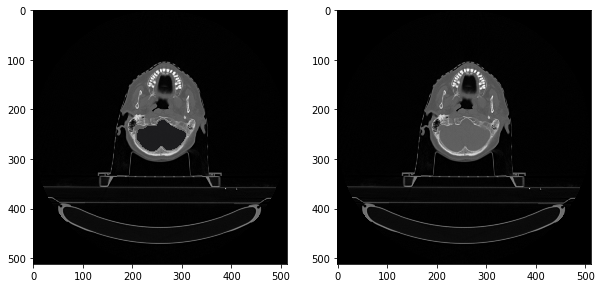

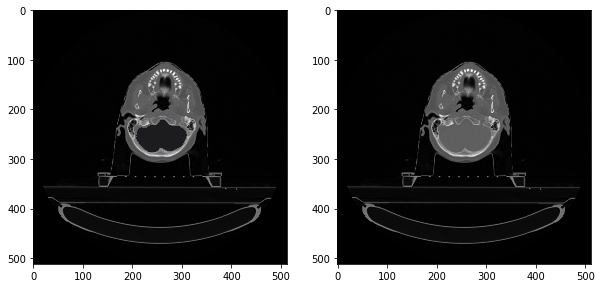

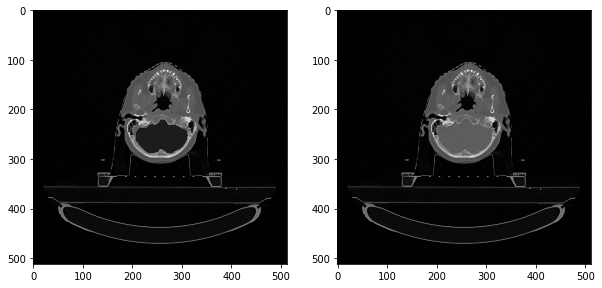

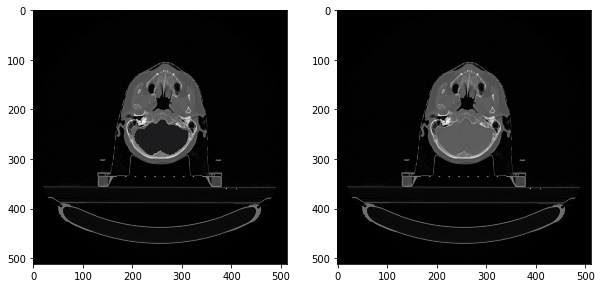

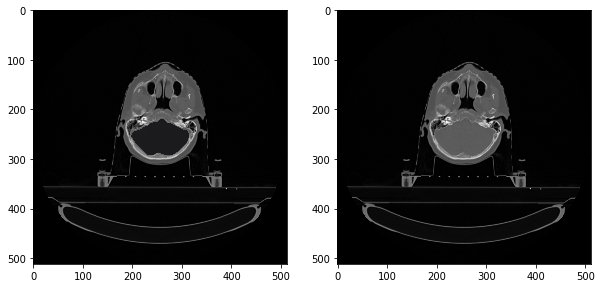

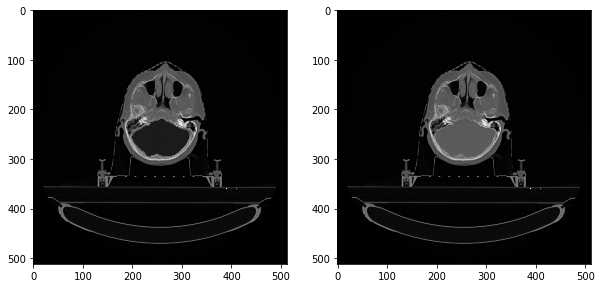

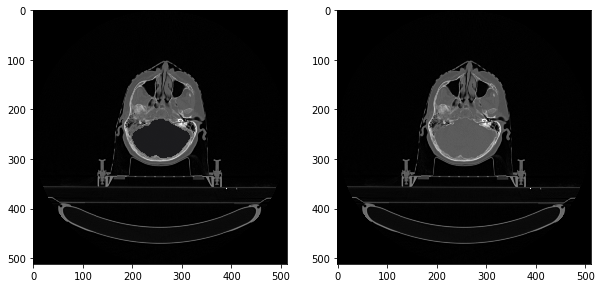

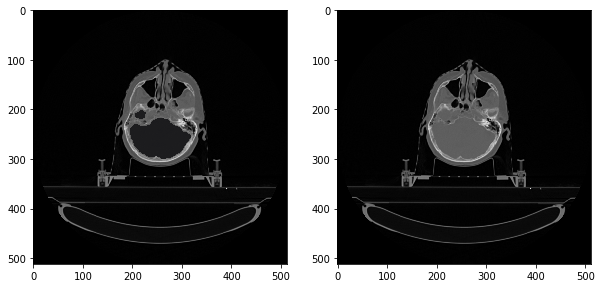

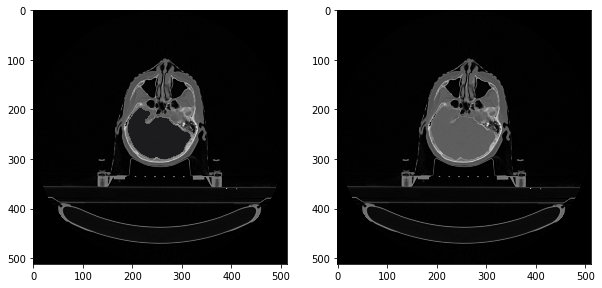

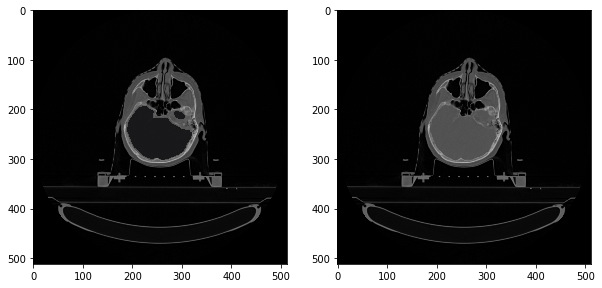

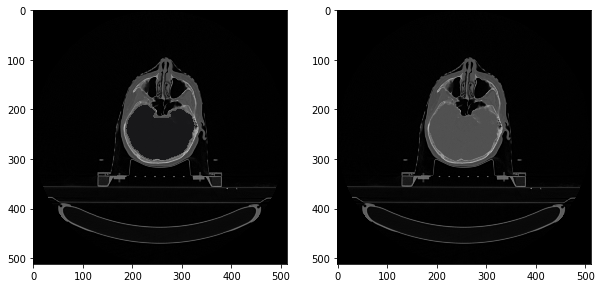

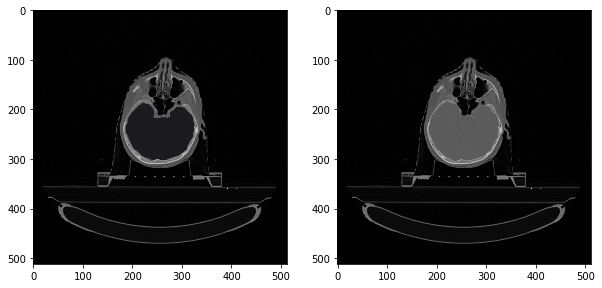

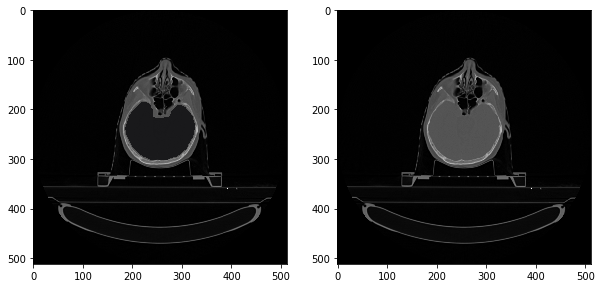

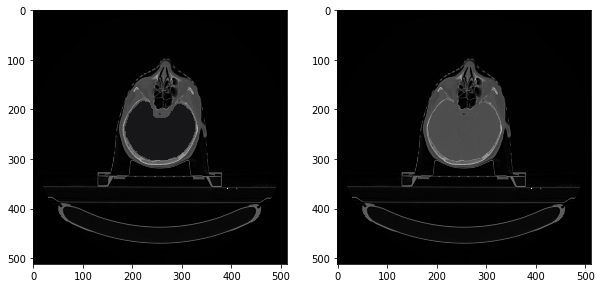

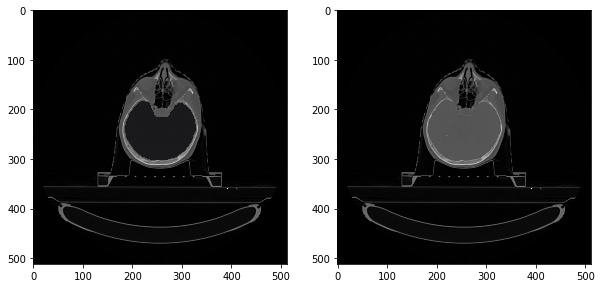

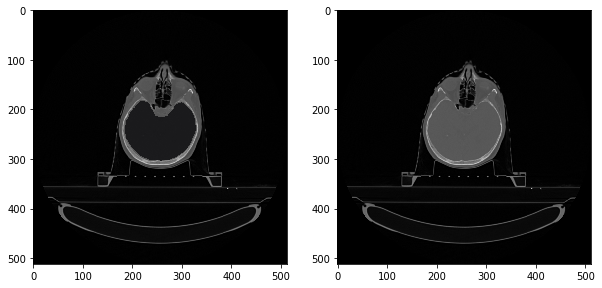

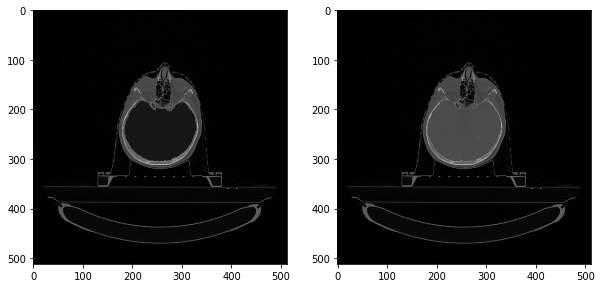

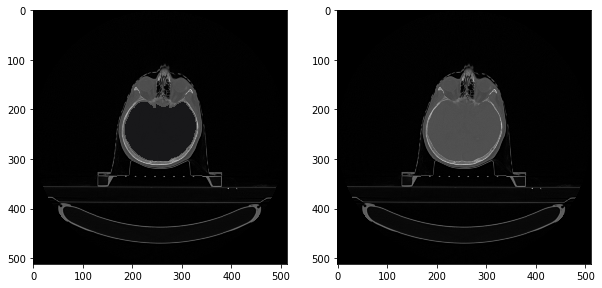

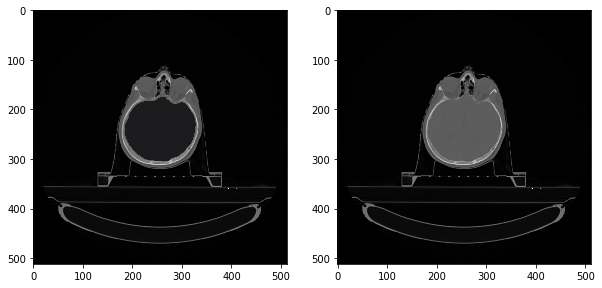

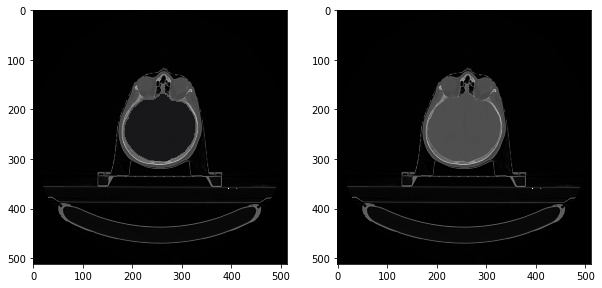

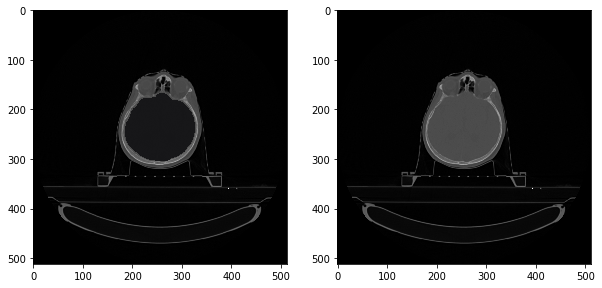

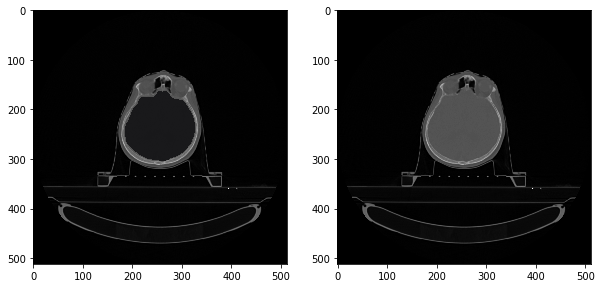

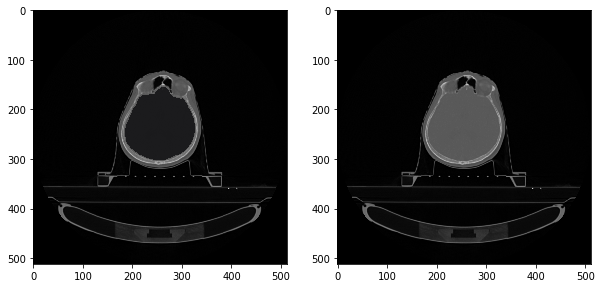

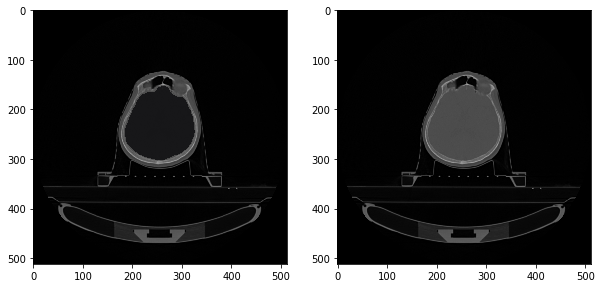

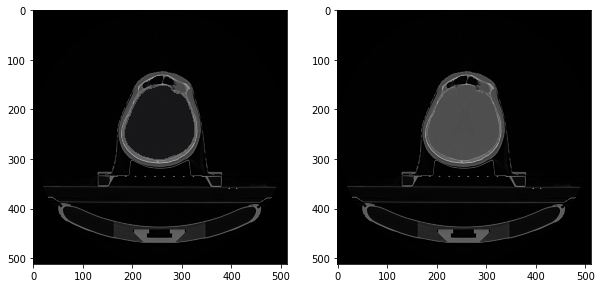

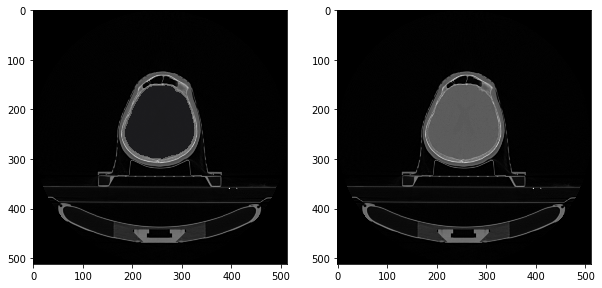

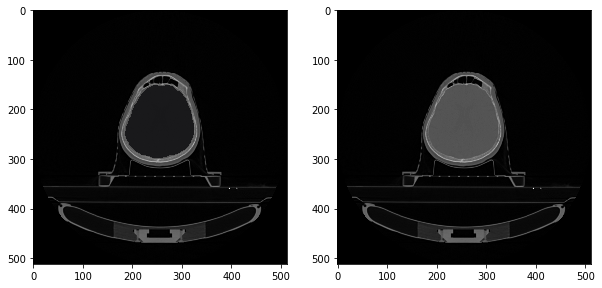

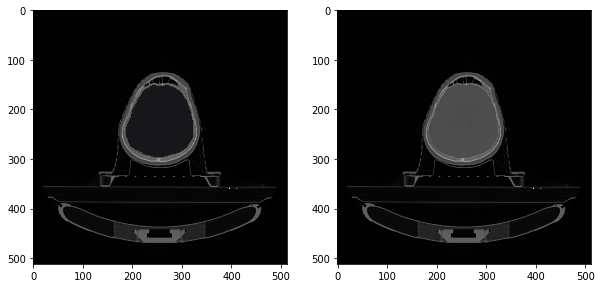

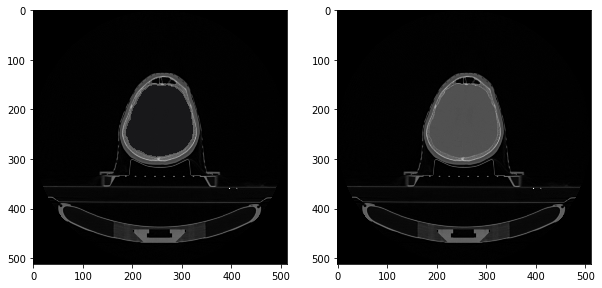

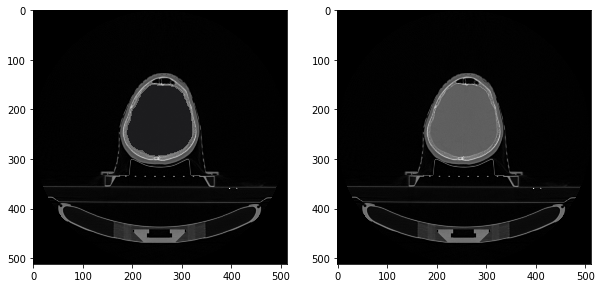

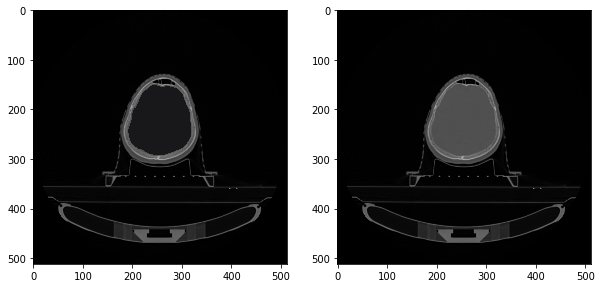

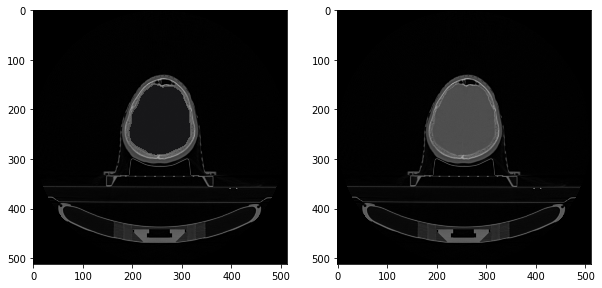

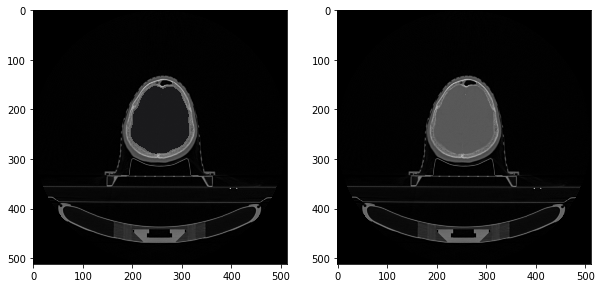

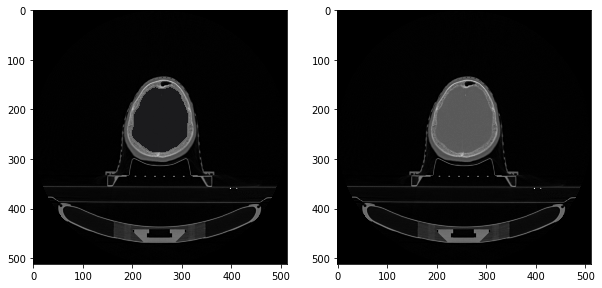

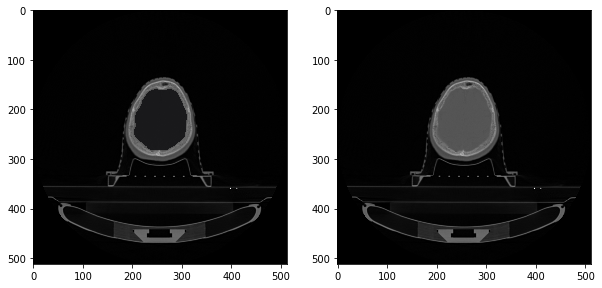

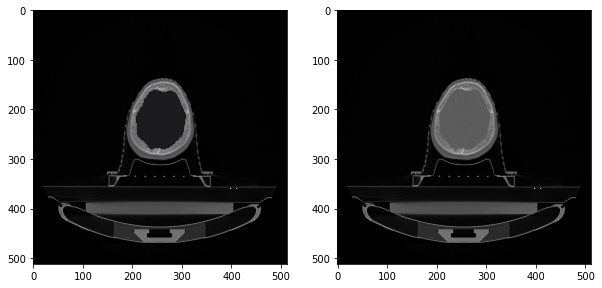

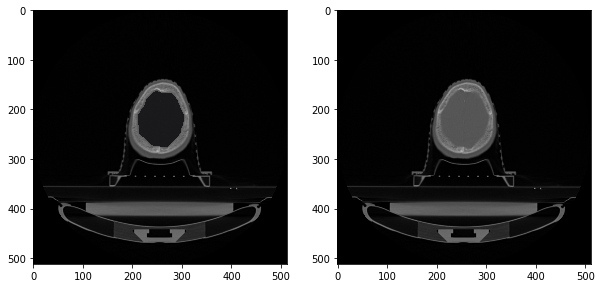

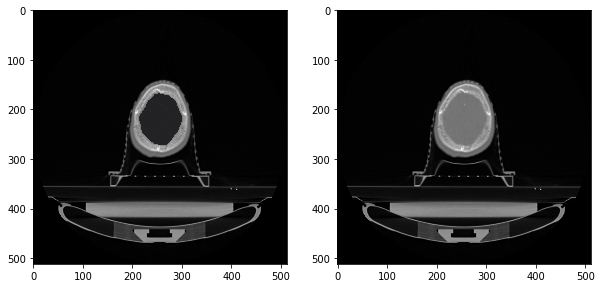

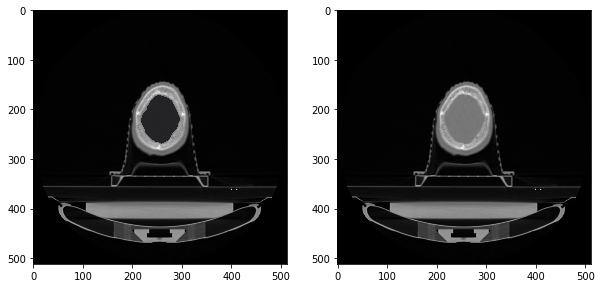

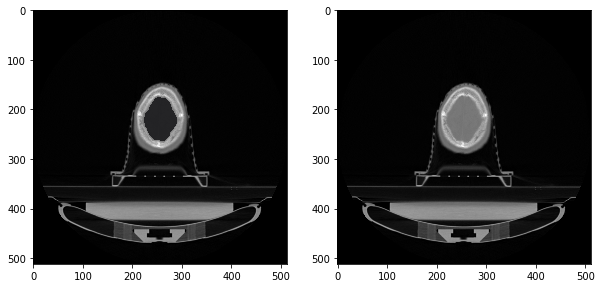

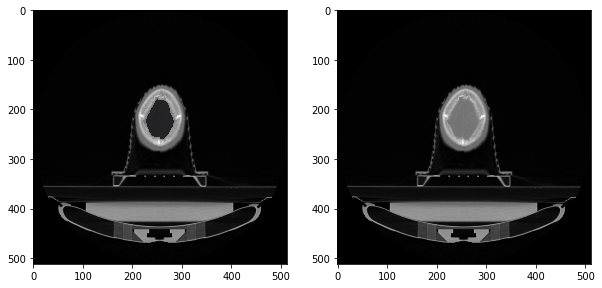

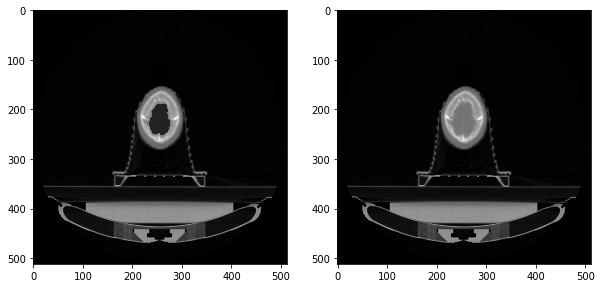

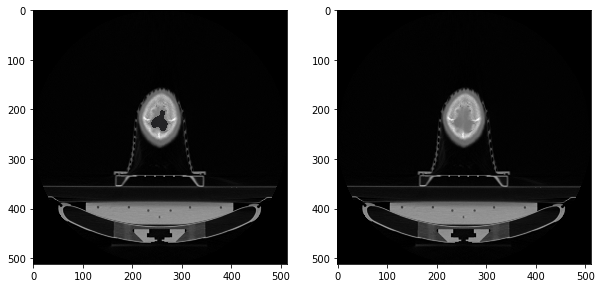

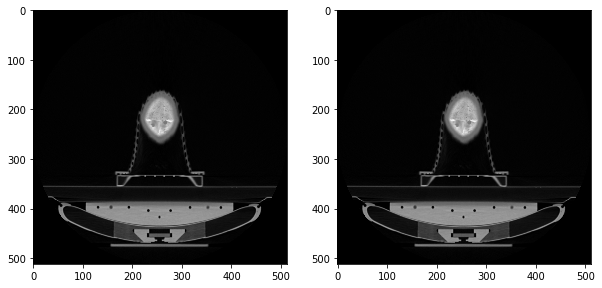

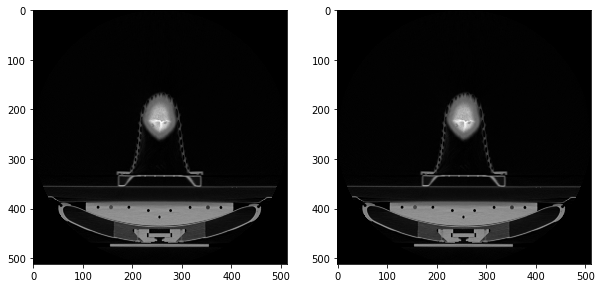

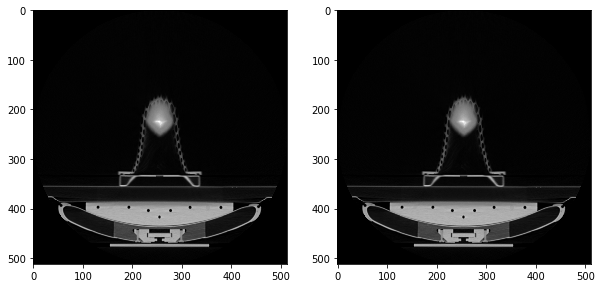

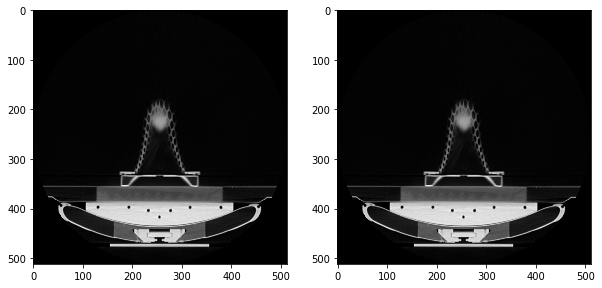

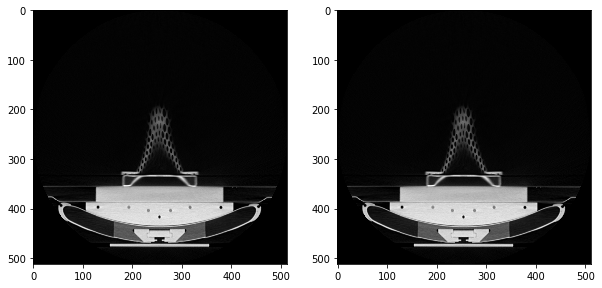

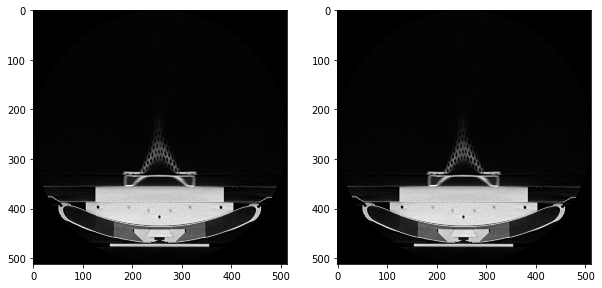

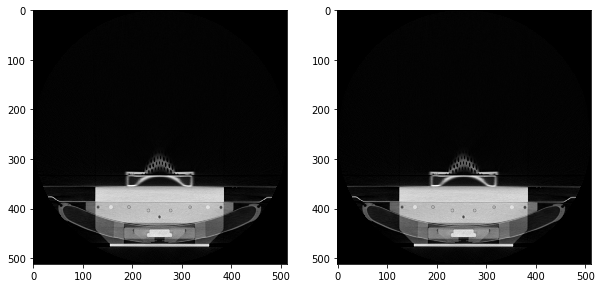

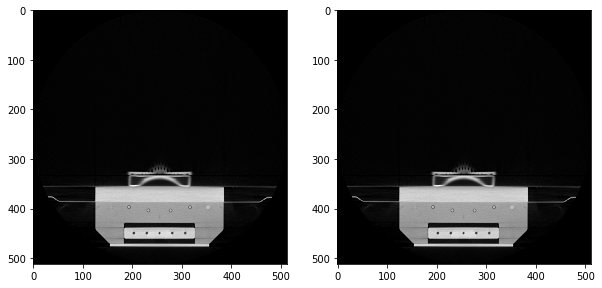

In [324]:
for img, mask in zip(img_voxel, mask_voxel):
    show_img_msk_fromarray(img, mask, sz=10, cmap='inferno', alpha=0.7)

In [230]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

In [240]:
scan = dicom.read_file(image_path + img_id + '.dcm').pixel_array

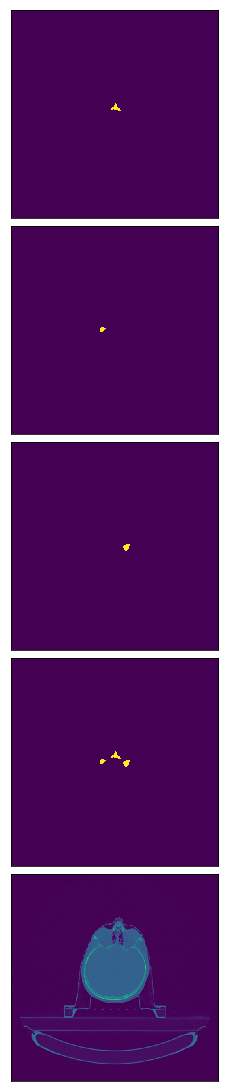

In [241]:
images = img_masks + [sum(img_masks)] + [scan]

fig, axes = plt.subplots(len(images),1, figsize=(15, 15))
for i,ax in enumerate(axes.flat): show_img(images[i], ax=ax)
plt.tight_layout(pad=0.1)

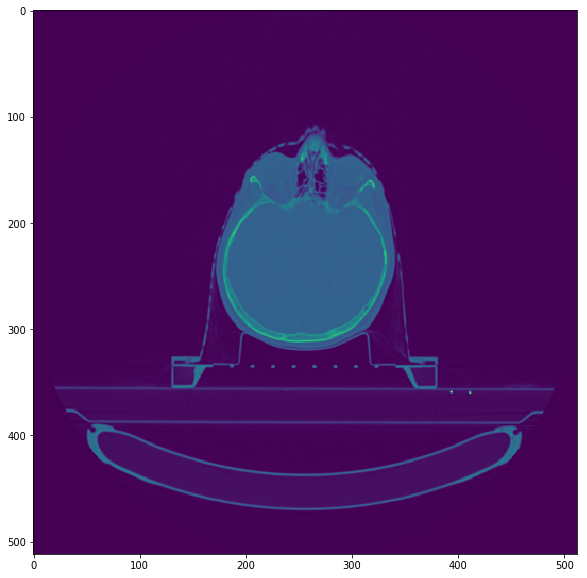

In [249]:
plt.figure(figsize=(15,10))
plt.imshow(scan)

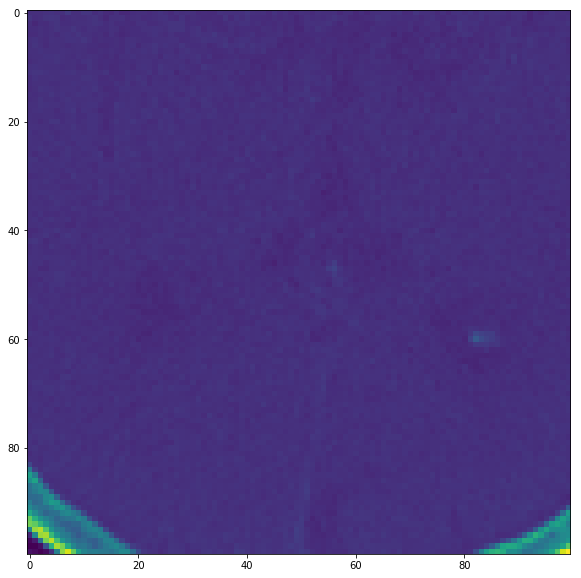

In [252]:
plt.figure(figsize=(15,10))
plt.imshow(scan[200:300, 200:300])

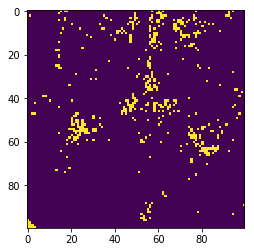

In [259]:
plt.imshow(scan[200:300, 200:300] < 1030)

In [ ]:
for v

In [166]:
def draw_img(img, sz = (5,5)):
    plt.figure(1, figsize=sz)
    plt.imshow(img)

In [103]:
mask = poly_to_mask(coords, *shape)

In [130]:
image = dicom.read_file(image_path + img_id + '.dcm').pixel_array

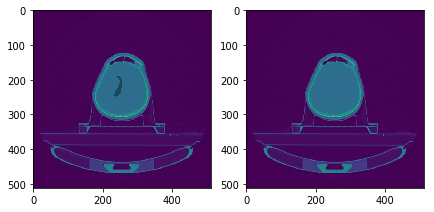

In [117]:
show_img_msk_fromarray(image, mask)

In [122]:
import seaborn as sns

In [137]:
roi = image[200:250, 200:250]

/home/kerem/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


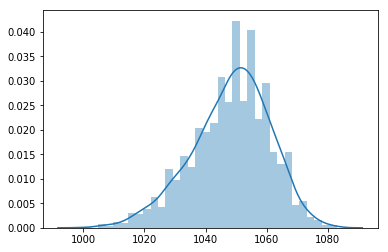

In [138]:
sns.distplot(roi.flatten())

In [140]:
roi

array([[1040, 1027, 1028, ..., 1029, 1034, 1040],
       [1045, 1047, 1065, ..., 1026, 1038, 1068],
       [1047, 1069, 1064, ..., 1056, 1040, 1042],
       ...,
       [1053, 1064, 1041, ..., 1047, 1051, 1059],
       [1063, 1056, 1048, ..., 1044, 1049, 1048],
       [1056, 1073, 1055, ..., 1054, 1054, 1050]], dtype=int16)

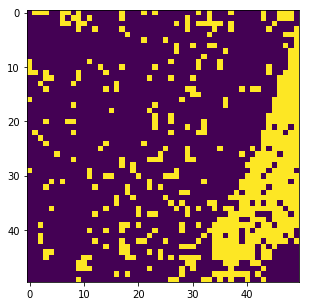

In [148]:
draw_img(roi<1040)

In [125]:
roi[roi < 1200] = 0

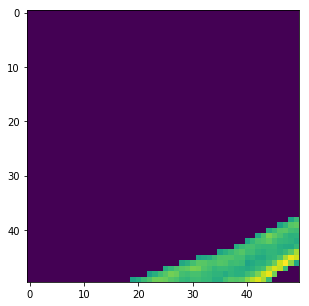

In [127]:
draw_img(roi)

In [119]:
roi_array = dicom_array * o_contour_array
if threshold == "auto":
    threshold = filters.threshold_otsu(roi_array[roi_array != 0])
roi_i_contour_proposal = (roi_array > threshold).astype(np.uint8)

array([[1027, 1050, 1061, ...,    4,   11,    0],
       [1049, 1053, 1052, ...,    7,   14,    0],
       [1053, 1065, 1042, ...,   24,   16,    0],
       ...,
       [  18,   29,   17, ...,    0,    0,    0],
       [  17,   15,   15, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0]], dtype=int16)